# Encoder Decoder Architecture 
Ref link: https://edumunozsala.github.io/BlogEms/fastpages/jupyter/encoder-decoder/lstm/attention/tensorflow%202/2020/10/07/Intro-seq2seq-Encoder-Decoder-ENG-SPA-translator-tf2.html#Intro-to-the-Encoder-Decoder-model-and-the-Attention-mechanism 


## A neural machine translator from english to spanish short sentences in tf2

### Importing the libraries and initialize global variables

In [1]:
import os
import gc
import time
import re
import unicodedata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

### We set the variables for data location

In [9]:
# Global parameters
#root folder
root_folder='../data'
#data_folder='.'
data_folder_name='spa_eng'
train_filename='spa.txt'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
print('DATA path',DATA_PATH)
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))
print('train_filenamepath',train_filenamepath)

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

DATA path V:\ML_projects\Transformer_end_to_end\data\spa_eng
train_filenamepath V:\ML_projects\Transformer_end_to_end\data\spa_eng\spa.txt


In [10]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 20000 #40000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM=1024 #512

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.

ATTENTION_FUNC='general'

### The dataset and text processing

For this exercise we will use pairs of simple sentences, the source in English and target in Spanish, from the Tatoeba project where people contribute adding translations every day. This is the link to some traslations in different languages. There you can download the Spanish - English spa_eng.zip file, it contains 124457 pairs of sentences.

The text sentences are almost clean, they are simple plain text, so we only need to remove accents, lower case the sentences and replace everything with space except (a-z, A-Z, ".", "?", "!", ","). The code to apply this preprocess has been taken from the Tensorflow tutorial for neural machine translation.



In [11]:
# Some function to preprocess the text data, taken from the Neural machine translation with attention tutorial
# in Tensorflow
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    ''' Preprocess the input text w applying lowercase, removing accents, 
    creating a space between a word and the punctuation following it and 
    replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    Input:
        - w: a string, input text
    Output:
        - a string, the cleaned text
    '''
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    
    return w

### Loading the datasets
Load the dataset into a pandas dataframe and apply the preprocess function to the input and target columns.

In [12]:
# Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(train_filenamepath, sep="\t", header=None, names=[INPUT_COLUMN,TARGET_COLUMN], usecols=[0,1], 
               nrows=NUM_SAMPLES)
# Preprocess the input data
input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is rigth shifted
target_input_data=df[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()

print(input_data[:5])
print(target_data[:5])
print(target_input_data[:5])

['go .', 'go .', 'go .', 'go .', 'hi .']
['ve . <eos>', 'vete . <eos>', 'vaya . <eos>', 'vayase . <eos>', 'hola . <eos>']
['<sos> ve .', '<sos> vete .', '<sos> vaya .', '<sos> vayase .', '<sos> hola .']


In [13]:
#Delete the dataframe and release the memory (if it is possible)
del df
gc.collect()

5638

### Tokenize and process the text data
Next, let's see how to prepare the data for our model. It is very simple and the steps are the following:

Tokenize the data, to convert the raw text into a sequence of integers. First, we create a Tokenizer object from the keras library and fit it to our text (one tokenizer for the input and another one for the output).
Extract sequence of integers from the text: we call the text_to_sequence method of the tokenizer for every input and output text.
Calculate the maximum length of the input and output sequences.

In [14]:
# Create a tokenizer for the input texts and fit it to them 
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_inputs.fit_on_texts(input_data)
# Tokenize and transform input texts to sequence of integers
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)
# Claculate the max length
input_max_len = max(len(s) for s in input_sequences)
print('Max Input Length: ', input_max_len)
# Show some example of tokenize sentences, useful to check the tokenization
print(input_data[1000])
print(input_sequences[1000])

Max Input Length:  8
tom tried .
[5, 412, 1]


In [15]:
# tokenize the outputs
# don't filter out special characters (filters = '')
# otherwise <sos> and <eos> won't appear
# By default, Keras’ Tokenizer will trim out all the punctuations, which is not what we want. 
# we can just set filters as blank here.

# Create a tokenizer for the output texts and fit it to them 
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)
# Tokenize and transform output texts to sequence of integers
target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)

# determine maximum length output sequence
target_max_len = max(len(s) for s in target_sequences)
print('Max Target Length: ', target_max_len)

print(target_data[1000])
print(target_sequences[1000])
print(target_input_data[1000])
print(target_sequences_inputs[1000])

Max Target Length:  18
tomas lo intento . <eos>
[62, 17, 767, 1, 2]
<sos> tomas lo intento .
[3, 62, 17, 767, 1]


In [16]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output and input words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1

# map indexes back into real words
# so we can view the results
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Found 3667 unique input tokens.
Found 7185 unique output tokens.


## Build an Encoder-Decoder model with Recurrent Neural Networks
The encoder: Layers of recurrent units where in each time step, receive a an input token, collects relevant information and produce a hidden state. Depends on the type of RNN, in our example a LSTM, the unit "mixes" the current hidden state and the input and return an output, discarded, and a new hidden state. You can read my post … for more information.

The encoder vector: it is the last hidden state of the encoder and it tries to contain as much of the useful input information as possible to help the decoder get the best results. It is only information from the input that the decoder will get.

The decoder: Layers of recurrent units, i.e. LSTMs, where each unit produces an output at a time step t. The hidden state of the first unit is the encoder vector and the rest of units accept the hidden state from the previous unit. The output is calculated using a softmax function to obtain a probability for every token in the output vocabulary.


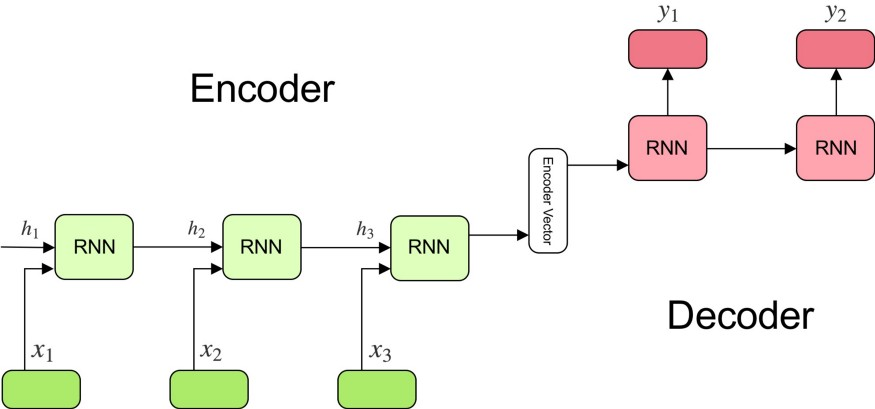

In [17]:
# pad the input sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
# pad the decoder input sequences
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
# pad the target output sequences
decoder_targets = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')

encoder_inputs.shape: (20000, 8)
encoder_inputs[0]: [29  1  0  0  0  0  0  0]
decoder_inputs[0]: [ 3 95  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
decoder_inputs.shape: (20000, 18)


In [18]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_inputs, decoder_targets))
dataset = dataset.shuffle(len(input_data)).batch(
    BATCH_SIZE, drop_remainder=True)

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)

    def call(self, input_sequence, states):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the LSTM unit
        output, state_h, state_c = self.lstm(embed, initial_state=states)

        return output, state_h, state_c

    def init_states(self, batch_size):
        # Return a all 0s initial states
        return (tf.zeros([batch_size, self.hidden_dim]),
                tf.zeros([batch_size, self.hidden_dim]))

In [20]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_sequence, state):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the LSTM unit
        lstm_out, state_h, state_c = self.lstm(embed, state)
        # Dense layer to predict output token
        logits = self.dense(lstm_out)

        return logits, state_h, state_c

In [21]:
#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1
#Create the encoder
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
# Get the initial states
initial_state = encoder.init_states(1)
# Call the encoder for testing
test_encoder_output = encoder(tf.constant(
    [[1, 23, 4, 5, 0, 0]]), initial_state)
print(test_encoder_output[0].shape)
# Create the decoder
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM)
# Get the initial states
de_initial_state = test_encoder_output[1:]
# Call the decoder for testing
test_decoder_output = decoder(tf.constant(
    [[1, 3, 5, 7, 9, 0, 0, 0]]), de_initial_state)
print(test_decoder_output[0].shape)

(1, 6, 1024)
(1, 8, 7186)


### Create the loss function and metrics

Now we need to define a custom loss function to avoid taking into account the 0 values, padding values, when calculating the loss. And also we have to define a custom accuracy function.

In [22]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    # Mask padding values, they do not have to compute for loss
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    # Calculate the loss value
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total

## Train the model
As we mentioned before, we are interested in training the network in batches, therefore, we create a function that carries out the training of a batch of the data:

Call the encoder for the batch input sequence, the output is the encoded vector.\
Set the decoder initial states to the encoded vector\
Call the decoder, taking the right shifted target sequence as input. The output are the logits (the softmax function is applied in the loss function)\
Calculate the loss and accuracy of the batch data\ 
Update the learnable parameters of the encoder and the decoder\
update the optimizer\

In [23]:
# Use the @tf.function decorator to take advance of static graph computation
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of arrays of shape [batch_size, hidden_dim].
            the initial state of the encoder
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
    with tf.GradientTape() as tape:
        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)
        # Set the encoder and decoder states
        en_states = en_outputs[1:]
        de_states = en_states
        # Get the encoder outputs
        de_outputs = decoder(target_seq_in, de_states)
        # Take the actual output
        logits = de_outputs[0]
        # Calculate the loss function
        loss = loss_func(target_seq_out, logits)
        acc = accuracy_fn(target_seq_out, logits)

    variables = encoder.trainable_variables + decoder.trainable_variables
    # Calculate the gradients for the variables
    gradients = tape.gradient(loss, variables)
    # Apply the gradients and update the optimizer
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, acc

In [24]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    
    losses = []
    accuracies = []

    for e in range(n_epochs):
        # Get the initial time
        start = time.time()
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        # For every batch data
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            # Train and get the loss value 
            loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
        
            if batch % 100 == 0:
                # Store the loss and accuracy values
                losses.append(loss)
                accuracies.append(accuracy)
                print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
                
        # saving (checkpoint) the model every 2 epochs
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses, accuracies

In [25]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 2.6825 Acc:0.0000
Epoch 1 Batch 100 Loss 1.3024 Acc:0.3842
Epoch 1 Batch 200 Loss 1.2114 Acc:0.3793
Epoch 1 Batch 300 Loss 1.1175 Acc:0.4588
Time taken for 1 epoch 321.2858 sec

Epoch 2 Batch 0 Loss 1.1074 Acc:0.4196
Epoch 2 Batch 100 Loss 1.0016 Acc:0.4545
Epoch 2 Batch 200 Loss 0.9329 Acc:0.5000
Epoch 2 Batch 300 Loss 0.9173 Acc:0.5031
Time taken for 1 epoch 318.6736 sec

Epoch 3 Batch 0 Loss 0.9059 Acc:0.4797
Epoch 3 Batch 100 Loss 0.8872 Acc:0.4985
Epoch 3 Batch 200 Loss 0.8931 Acc:0.5154
Epoch 3 Batch 300 Loss 0.8591 Acc:0.5185
Time taken for 1 epoch 317.6705 sec

Epoch 4 Batch 0 Loss 0.7322 Acc:0.5251
Epoch 4 Batch 100 Loss 0.7260 Acc:0.5552
Epoch 4 Batch 200 Loss 0.7045 Acc:0.5701
Epoch 4 Batch 300 Loss 0.7852 Acc:0.5581
Time taken for 1 epoch 319.2964 sec

Epoch 5 Batch 0 Loss 0.6592 Acc:0.5706
Epoch 5 Batch 100 Loss 0.6106 Acc:0.5936
Epoch 5 Batch 200 Loss 0.6220 Acc:0.6052
Epoch 5 Batch 300 Loss 0.6258 Acc:0.5959
Time taken for 1 epoch 313.4760 sec

Epoch

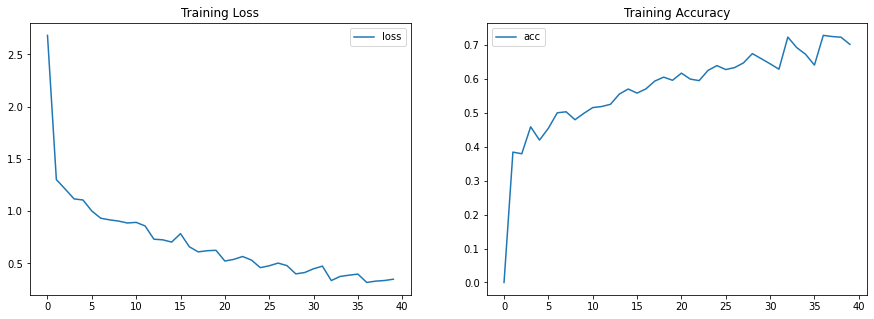

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [27]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint_dir = './training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [28]:
def predict(input_text, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
        print(input_text)
    # Tokenize the input sequence
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    print(input_seq)
    # Set the encoder initial state
    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Create the decoder input, the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the decoder states to the encoder vector or encoder hidden state
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    while True:
        # Decode and get the output probabilities
        de_output, de_state_h, de_state_c = decoder(
            de_input, (de_state_h, de_state_c))
        # Select the word with the highest probability
        de_input = tf.argmax(de_output, -1)
        # Append the word to the predicted output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Finish when eos token is found or the max length is reached
        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break

    print(' '.join(out_words))

In [29]:
test_sents = [input_data[10003], input_data[10120]]
#test_sents = [encoder_inputs[1000]]
print(test_sents)
for test_sent in test_sents:
    predict(test_sent, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs)

['it won t matter .', 'let me call tom .']
[[  6 103  10 709   1   0   0   0]]
no sera facil . <eos>
[[ 41  15 122   5   1   0   0   0]]
dejame ayudarte . <eos>
